In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import subprocess
np.random.seed(42)

In [2]:
# Load the data
df = pd.read_csv("csv/ems_data.csv")
print("CSV Loaded, Dataset shape:", df.shape)

CSV Loaded, Dataset shape: (154, 6)


In [3]:
if not os.path.exists("pickles"):
    os.makedirs("pickles")

In [4]:
# Preprocess the data
# Label encode the species column
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])

In [5]:
# Save label encoder
with open('pickles/label_encoding.pkl', 'wb') as f:
    pickle.dump(le, f)

In [6]:
# Scale numerical features
scaler = MinMaxScaler()
numerical_columns = ['soakDuration', 'lowestTemp', 'highestTemp']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [7]:
# Save scaler
with open('pickles/scaler_encoding.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [8]:
# Prepare features and target
X = df[['species', 'emsConcentration', 'soakDuration', 'lowestTemp', 'highestTemp']]
y = df['result']

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Save the model
with open('pickles/ems_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')

In [13]:
scores

array([0.8125    , 0.75      , 0.75      , 0.8125    , 0.6       ,
       0.53333333, 0.8       , 0.73333333, 0.66666667, 0.66666667])

In [14]:
scores.mean()

np.float64(0.7125)

In [15]:
scores.std()

np.float64(0.08936504412303009)

In [16]:
print(f"Model Accuracy Score: {round(rf_model.score(X_test, y_test) * 100,1)}%")

Model Accuracy Score: 87.5%


In [19]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.33      0.50         3

    accuracy                           0.88        16
   macro avg       0.93      0.67      0.71        16
weighted avg       0.89      0.88      0.85        16



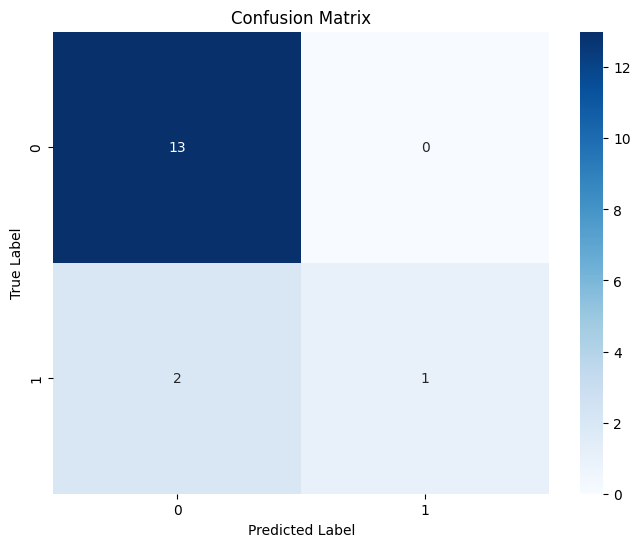

In [20]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
confusion_df = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])\
    .rename_axis(index={'Actual': 'Actual'}, columns={'Predicted': 'Predicted'})\
    .set_axis(['Fail rate', 'Success rate'], axis=0)\
    .set_axis(['Fail rate', 'Success rate'], axis=1)
print(confusion_df)

              Fail rate  Success rate
Fail rate            13             0
Success rate          2             1


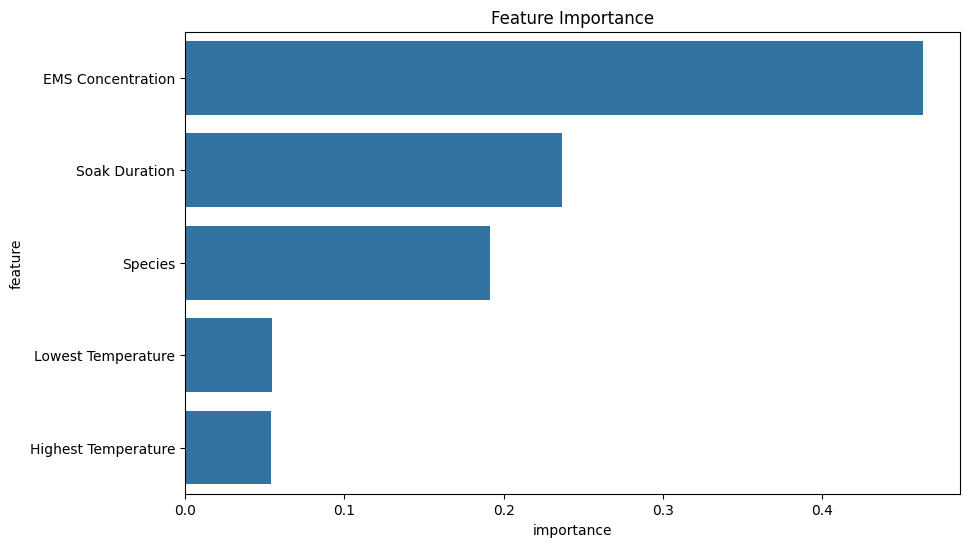

In [22]:
feature_names = ['Species', 'EMS Concentration', 'Soak Duration', 'Lowest Temperature', 'Highest Temperature']
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()